In [1]:
import py_midicsv as pm
import pandas as pd
import io
import numpy as np
from hmmlearn import hmm
from matplotlib import pyplot as plt

import mido
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import colorConverter

In [13]:
# inherit the origin mido class
class MidiFile(mido.MidiFile):

    def __init__(self, filename):

        mido.MidiFile.__init__(self, filename)
        self.sr = 10
        self.meta = {}
        self.events = self.get_events()

    def get_events(self):
        mid = self
#         print(mid)

        # There is > 16 channel in midi.tracks. However there is only 16 channel related to "music" events.
        # We store music events of 16 channel in the list "events" with form [[ch1],[ch2]....[ch16]]
        # Lyrics and meta data used a extra channel which is not include in "events"

        events = [[] for x in range(16)]

        # Iterate all event in the midi and extract to 16 channel form
        for track in mid.tracks:
            for msg in track:
                try:
                    channel = msg.channel
                    events[channel].append(msg)
                except AttributeError:
                    try:
                        if type(msg) != type(mido.UnknownMetaMessage):
                            self.meta[msg.type] = msg.dict()
                        else:
                            pass
                    except:
                        print("error",type(msg))

        return events

    def get_roll(self):
        events = self.get_events()
        # Identify events, then translate to piano roll
        # choose a sample ratio(sr) to down-sample through time axis
        sr = self.sr

        # compute total length in tick unit
        length = self.get_total_ticks()

        # allocate memory to numpy array
        roll = np.zeros((16, 128, length // sr), dtype="int8")

        # use a register array to save the state(no/off) for each key
        note_register = [int(-1) for x in range(128)]

        # use a register array to save the state(program_change) for each channel
        timbre_register = [1 for x in range(16)]


        for idx, channel in enumerate(events):

            time_counter = 0
            volume = 100
            # Volume would change by control change event (cc) cc7 & cc11
            # Volume 0-100 is mapped to 0-127

            for msg in channel:
                if msg.type == "control_change":
                    if msg.control == 7:
                        volume = msg.value
                        # directly assign volume
                    if msg.control == 11:
                        volume = volume * msg.value // 127
                        
                if msg.type == "program_change":
                    timbre_register[idx] = msg.program

                if msg.type == "note_on":
                    note_on_start_time = time_counter // sr
                    note_on_end_time = (time_counter + msg.time) // sr
                    intensity = volume * msg.velocity // 127



                    # When a note_on event *ends* the note start to be play 
                    # Record end time of note_on event if there is no value in register
                    # When note_off event happens, we fill in the color
                    if note_register[msg.note] == -1:
                        note_register[msg.note] = (note_on_end_time,intensity)
                    else:
                    # When note_on event happens again, we also fill in the color
                        old_end_time = note_register[msg.note][0]
                        old_intensity = note_register[msg.note][1]
                        roll[idx, msg.note, old_end_time: note_on_end_time] = old_intensity
                        note_register[msg.note] = (note_on_end_time,intensity)


                if msg.type == "note_off":
                    note_off_start_time = time_counter // sr
                    note_off_end_time = (time_counter + msg.time) // sr
                    note_on_end_time = note_register[msg.note][0]
                    intensity = note_register[msg.note][1]
                    # fill in color
                    roll[idx, msg.note, note_on_end_time:note_off_end_time] = intensity

                    note_register[msg.note] = -1  # reinitialize register

                time_counter += msg.time

                # TODO : velocity -> done, but not verified
                # TODO: Pitch wheel
                # TODO: Channel - > Program Changed / Timbre catagory
                # TODO: real time scale of roll

            # if there is a note not closed at the end of a channel, close it
            for key, data in enumerate(note_register):
                if data != -1:
                    note_on_end_time = data[0]
                    intensity = data[1]
                    # print(key, note_on_end_time)
                    note_off_start_time = time_counter // sr
                    roll[idx, key, note_on_end_time:] = intensity
                note_register[idx] = -1

        return roll

    def get_roll_image(self):
        roll = self.get_roll()
        plt.ioff()

        K = 16

        transparent = colorConverter.to_rgba('black')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / K, 1, 1)), alpha=1) for i in range(K)]
        color = 'yellow'
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, color], 128) for i in
                 range(K)]

        for i in range(K):
            cmaps[i]._init()  # create the _lut array, with rgba values
            # create your alpha array and fill the colormap with them.
            # here it is progressive, but you can create whathever you want
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            cmaps[i]._lut[:, -1] = alphas

        fig = plt.figure(figsize=(4, 3))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
        a1.set_facecolor("black")

        array = []

        for i in range(K):
            try:
                img = a1.imshow(roll[i], interpolation='nearest', cmap=cmaps[i], aspect='auto')
                array.append(img.get_array())
            except IndexError:
                pass
        return array

    def draw_roll(self):


        roll = self.get_roll()

        # build and set fig obj
        plt.ioff()
        fig = plt.figure(figsize=(10, 8))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
        a1.set_facecolor("black")

        # change unit of time axis from tick to second
        tick = self.get_total_ticks()
        second = mido.tick2second(tick, self.ticks_per_beat, self.get_tempo())
        if second > 10:
            x_label_period_sec = second // 10
        else:
            x_label_period_sec = second / 10  # ms
        x_label_interval = mido.second2tick(x_label_period_sec, self.ticks_per_beat, self.get_tempo()) / self.sr
        plt.xticks([int(x * x_label_interval) for x in range(20)], [round(x * x_label_period_sec, 2) for x in range(20)])

        # change scale and label of y axis
        plt.yticks([y*16 for y in range(8)], [y*16 for y in range(8)])

        # build colors
        channel_nb = 16
        transparent = colorConverter.to_rgba('white')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / channel_nb, 1, 1)), alpha=1) for i in range(channel_nb)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, 'white'], 128) for i in
                 range(channel_nb)]


        # build color maps
        for i in range(channel_nb):
            cmaps[i]._init()
            # create your alpha array and fill the colormap with them.
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            # create the _lut array, with rgba values
            cmaps[i]._lut[:, -1] = alphas


        # draw piano roll and stack image on a1
        for i in range(channel_nb):
            try:
                a1.imshow(roll[i], origin="lower", interpolation='nearest', cmap=cmaps[i], aspect='auto')
            except IndexError:
                pass
#         plt.xlim(right=2000)
        
        # show piano roll
        plt.draw()
        plt.ion()
        plt.title('Notes Over Time')
        plt.ylabel('note on the piano')
        plt.xlabel('time in seconds')
        plt.savefig('tree_music.pdf')
        plt.show(block=True)

    def get_tempo(self):
        try:
            return self.meta["set_tempo"]["tempo"]
        except:
            return 500000

    def get_total_ticks(self):
        max_ticks = 0
        for channel in range(16):
            ticks = sum(msg.time for msg in self.events[channel])
            if ticks > max_ticks:
                max_ticks = ticks
        return max_ticks

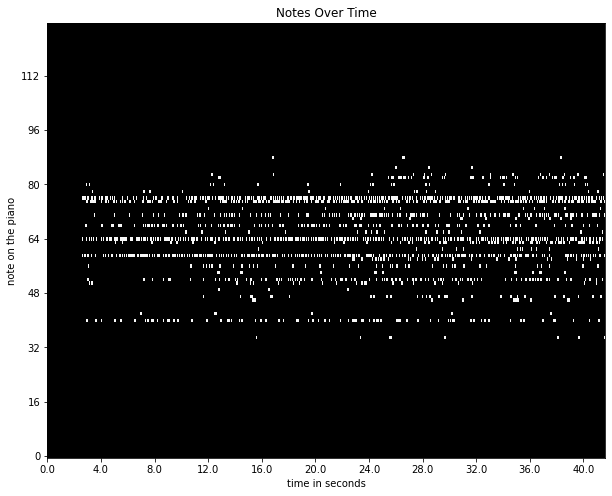

500000

In [14]:
# if __name__ == "__main__":
mid = MidiFile("tree_music.midi")

# get the list of all events
# events = mid.get_events()

# get the np array of piano roll image
roll = mid.get_roll()

# draw piano roll by pyplot
mid.draw_roll()
mid.get_tempo()

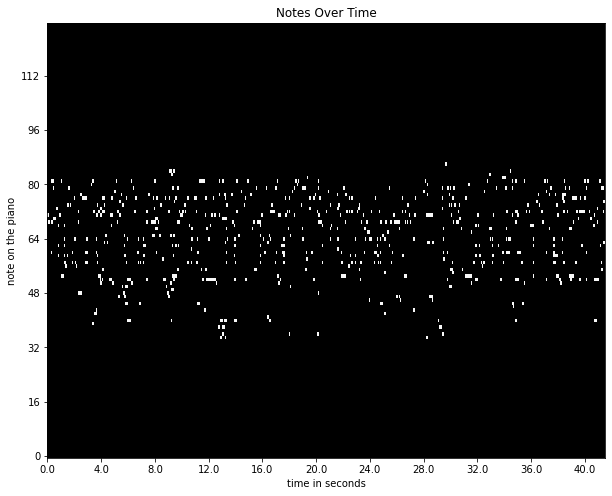

500000

In [15]:
# if __name__ == "__main__":
mid = MidiFile("tree_music2.midi")

# get the list of all events
# events = mid.get_events()

# get the np array of piano roll image
roll = mid.get_roll()

# draw piano roll by pyplot
mid.draw_roll()
mid.get_tempo()

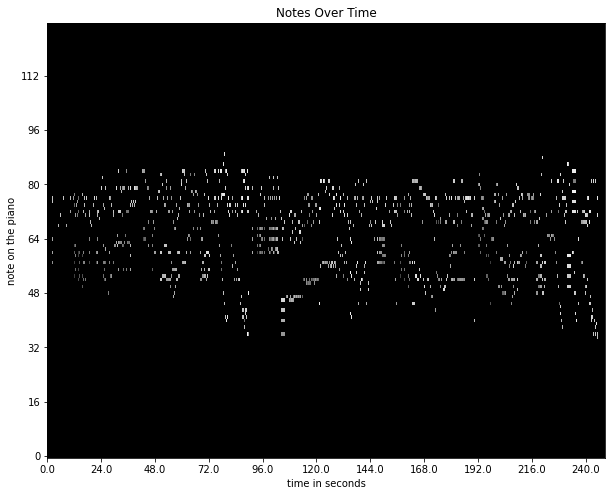

491803

In [16]:
# if __name__ == "__main__":
mid = MidiFile("Study_Music/piano_sonata_310_1_(c)oguri.mid")

# get the list of all events
# events = mid.get_events()

# get the np array of piano roll image
roll = mid.get_roll()

# draw piano roll by pyplot
mid.draw_roll()
mid.get_tempo()